# 5. Machine Learning Contd. - 2

## In Depth: k-Means Clustering

* The “cluster center” is the arithmetic mean of all the points belonging to the cluster.

* Each point is closer to its own cluster center than to other cluster centers.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
import numpy as np

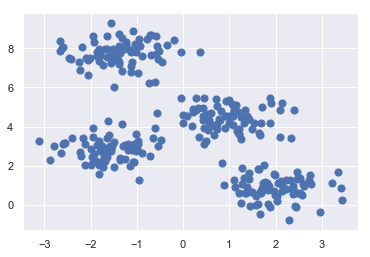

In [4]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                      cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [5]:
from sklearn.cluster import KMeans ######################

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)

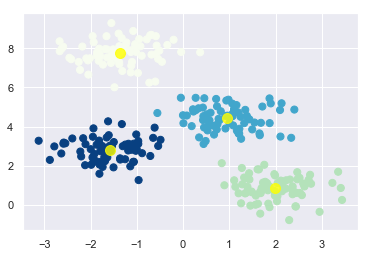

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap=plt.cm.GnBu)

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='yellow', s=100, alpha=0.8);

In [7]:
centers

array([[-1.37324398,  7.75368871],
       [ 1.98258281,  0.86771314],
       [ 0.94973532,  4.41906906],
       [-1.58438467,  2.83081263]])

### k-Means Algorithm: Expectation–Maximization

![](kmeans.png)

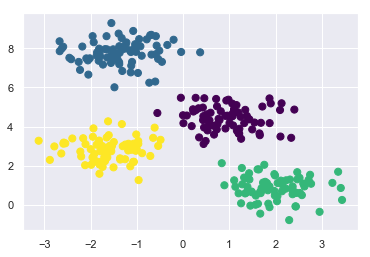

In [8]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
       # 2a. Assign labels based on closest center
       labels = pairwise_distances_argmin(X, centers)

       # 2b. Find new centers from means of points
       new_centers = np.array([X[labels == i].mean(0)
                               for i in range(n_clusters)])

       # 2c. Check for convergence
       if np.all(centers == new_centers):
            break
       centers = new_centers

    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

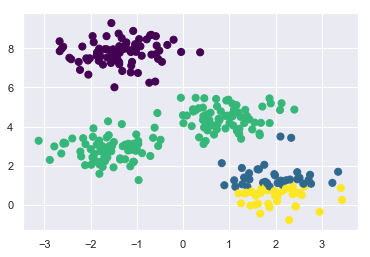

In [9]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, **it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the `n_init` parameter, which defaults to 10)**

**Another common challenge with k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.**

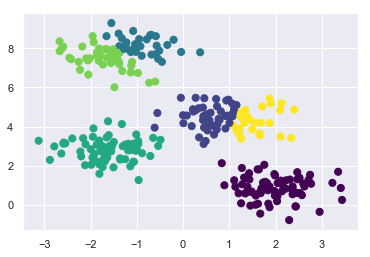

In [10]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');


Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., `Gaussian` mixture models; or which can choose a suitable number of clusters (e.g., `DBSCAN`, `mean-shift`)

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries.

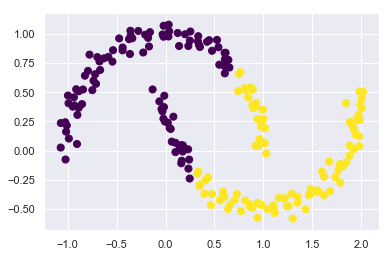

In [11]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

we used a kernel transformation in Support Vector Machines to project the data into a higher dimension where a linear separation is possible

One version of this kernelized k-means is implemented in Scikit-Learn within the `SpectralClustering` estimator.

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


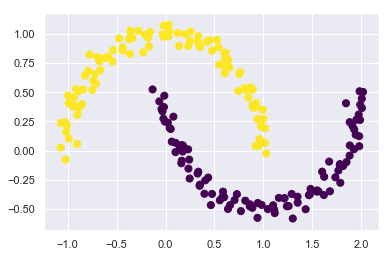

In [12]:
from sklearn.cluster import SpectralClustering ##################

model = SpectralClustering(n_clusters=2,
                           affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized k-means is able to find the more complicated nonlinear boundaries between clusters.

### EXAMPLE 1: K-MEANS ON DIGITS

In this example, we will attempt to use k-means to try to identify similar digits without using the original label information

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [14]:
kmeans = KMeans(n_clusters=10, random_state=0) ################
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

In [15]:
clusters

array([5, 7, 7, ..., 7, 3, 3], dtype=int32)

Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the “typical” digit within the cluster.

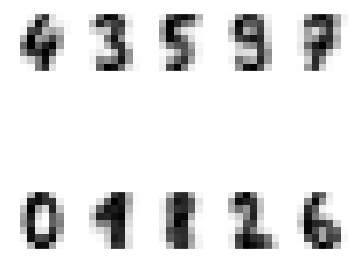

In [16]:
fig = plt.figure(figsize=(6, 6))

for i, image in enumerate(kmeans.cluster_centers_):
    
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(image.reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')

We see that even without the labels, KMeans is able to find clusters whose centers are recognizable digits

In [17]:
from scipy.stats import mode

labels = np.zeros_like(clusters)

for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [18]:
labels

array([0, 8, 8, ..., 8, 9, 9], dtype=int32)

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(digits.target, labels)

0.7935447968836951

With just a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits!

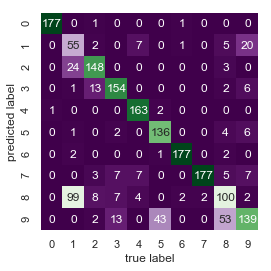

In [20]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(digits.target, labels)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap=plt.cm.PRGn, cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to preprocess the data before performing k-means.

In [21]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9398998330550918

In [22]:
digits_proj.shape

(1797, 2)

In [23]:
clusters.shape

(1797,)

That’s nearly 94% classification accuracy without using the labels.

In [24]:
digits.target[(clusters == 1)]

array([5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 5, 9, 5, 9, 9, 5, 5, 9, 9, 5, 9, 9, 5, 9, 9, 5, 5, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9,
       9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9])

In [25]:
digits.target[(clusters == 1)].shape

(156,)

In [26]:
mode(digits.target[(clusters == 1)]) 
# 12 5, 144 9

ModeResult(mode=array([9]), count=array([144]))

### EXAMPLE 2: K-MEANS FOR COLOR COMPRESSION

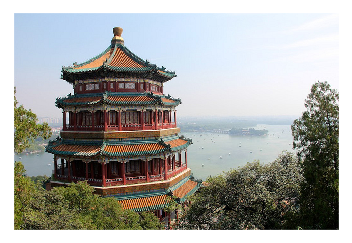

In [27]:
# Note: this requires the pillow package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [28]:
china.shape

(427, 640, 3)

In [29]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

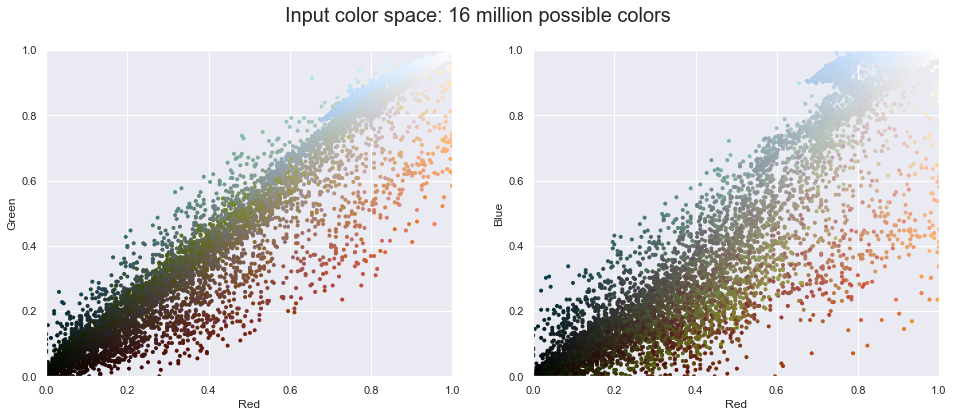

In [30]:
 def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

plot_pixels(data, title='Input color space: 16 million possible colors')

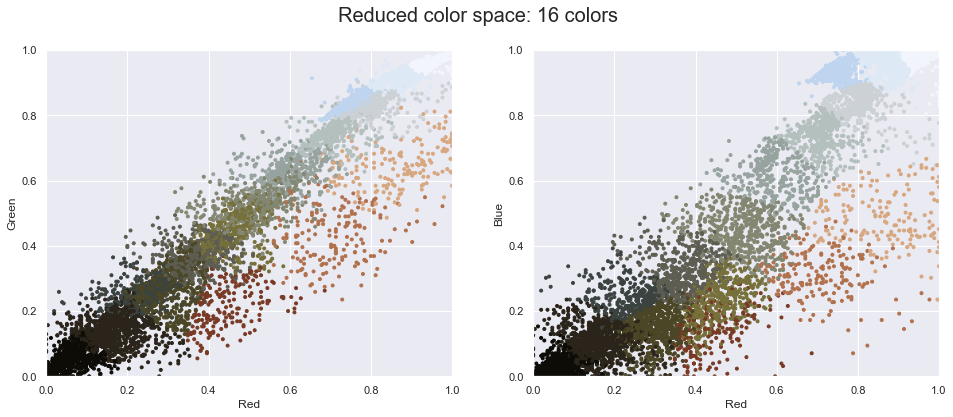

In [31]:
from sklearn.cluster import MiniBatchKMeans #################

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

In [32]:
new_colors.shape

(273280, 3)

In [33]:
kmeans.predict(data)

array([5, 5, 5, ..., 4, 2, 2], dtype=int32)

In [34]:
kmeans.predict(data).shape

(273280,)

In [35]:
kmeans.cluster_centers_

array([[0.87001435, 0.91389287, 0.96312769],
       [0.29312599, 0.27581699, 0.1481181 ],
       [0.05515294, 0.04746667, 0.02638431],
       [0.51339072, 0.53075084, 0.44514586],
       [0.16314764, 0.14068303, 0.1057525 ],
       [0.74850949, 0.83599554, 0.93620277],
       [0.84420677, 0.65329768, 0.5       ],
       [0.3668175 , 0.36581197, 0.32001006],
       [0.70521768, 0.75393819, 0.74204055],
       [0.94721112, 0.96038454, 0.9850752 ],
       [0.69822596, 0.44145658, 0.3038282 ],
       [0.22967074, 0.26163522, 0.25186829],
       [0.7998176 , 0.81901505, 0.83602371],
       [0.46932321, 0.22694497, 0.14244149],
       [0.59282279, 0.63795782, 0.61768405],
       [0.46088401, 0.44094384, 0.22897973]])

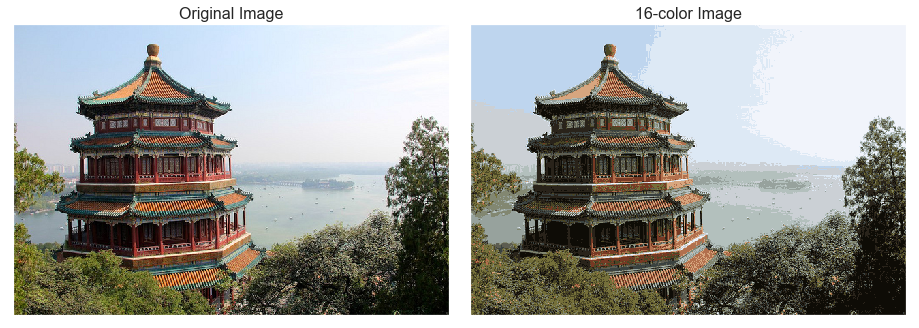

In [36]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)

ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

In [37]:
china_recolored.shape

(427, 640, 3)

## In Depth: Gaussian Mixture Models

In particular, the nonprobabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations

Gaussian mixture models, which can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering

### Motivating GMM: Weaknesses of k-Means

In [38]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                      cluster_std=0.60, random_state=0)

print(X.shape)

X = X[:, ::-1] # flip axes for better plotting

(400, 2)


In [39]:
X.shape

(400, 2)

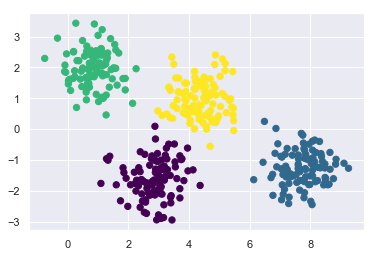

In [40]:
# Plot the data with k-means labels
from sklearn.cluster import KMeans

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

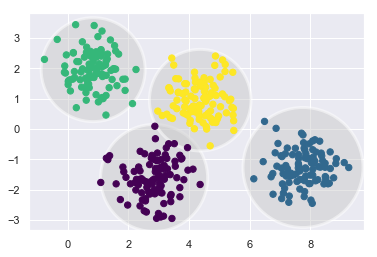

In [41]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the k-means model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

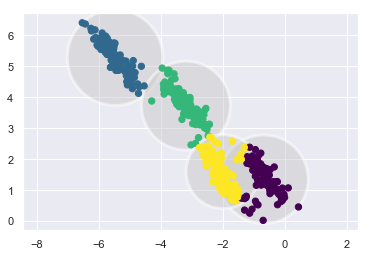

In [42]:
rng = np.random.RandomState(13)

X_stretched = np.dot(X, rng.randn(2, 2)) #######################

kmeans = KMeans(n_clusters=4, random_state=0)   #######################
plot_kmeans(kmeans, X_stretched)

These **two disadvantages of k-means**—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

### Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multidimensional Gaussian probability distributions that best model any input dataset.

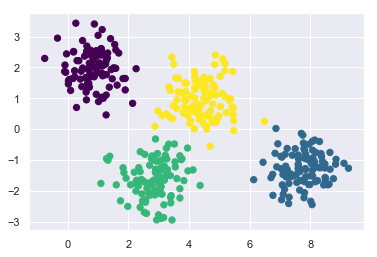

In [43]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
# GMMs can be used for finding clusters in the same manner as k-means

`predict_proba method` returns a matrix of size `[n_samples, n_clusters]` that measures the probability that any point belongs to the given cluster:

In [44]:
labels[:5]

array([3, 2, 2, 3, 2])

In [45]:
probs = gmm.predict_proba(X)  #######################
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


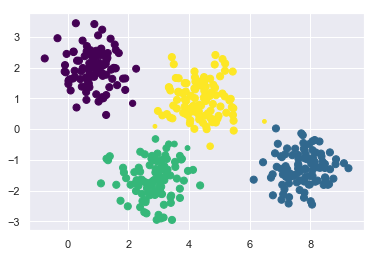

In [46]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [47]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

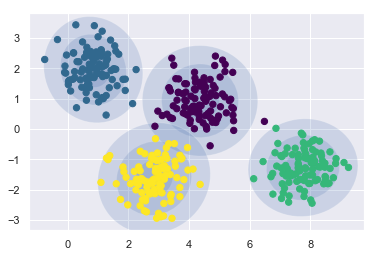

In [48]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the `GaussianMixture` approach to fit our stretched dataset; allowing for a full covariance, the model will fit even very oblong, stretched-out clusters:

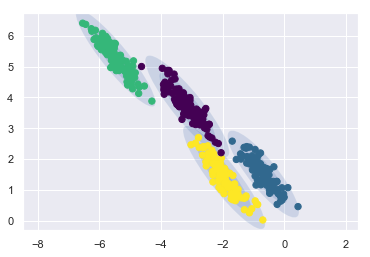

In [49]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42) #######################
plot_gmm(gmm, X_stretched)

**This makes clear that GaussianMixture address the two main practical issues with k-means encountered before.**

### CHOOSING THE COVARIANCE TYPE

 `covariance_type` hyperparameter controls the degrees of freedom in the shape of each cluster.A more complicated and computationally expensive model is the `full` type while a slightly simpler and faster model is `covariance_type="spherical"`

![](covariancepng.png)

### GaussianMixture as Density Estimation

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation.

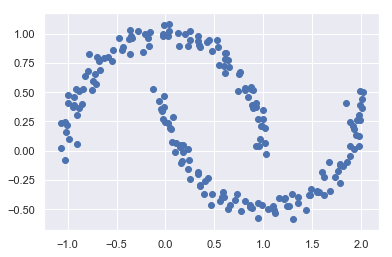

In [50]:
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

the results are not particularly useful, If we try to fit this to a two-component GMM viewed as a clustering model:

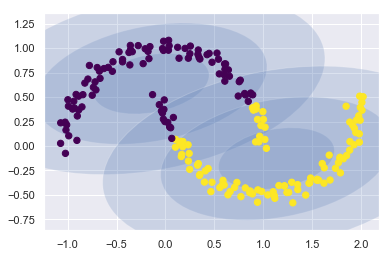

In [51]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data

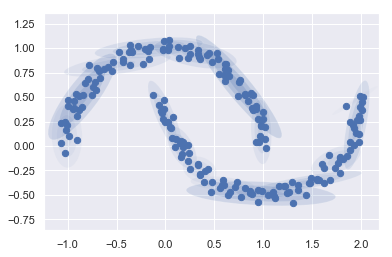

In [52]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

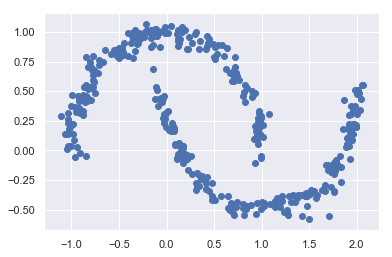

In [60]:
Xnew = gmm16.sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

In [62]:
Xnew.shape

(400, 2)

### HOW MANY COMPONENTS?

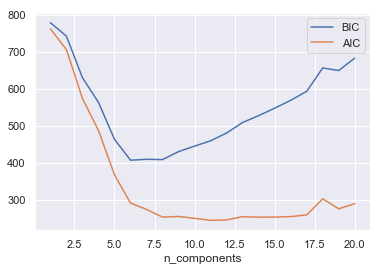

In [63]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The AIC tells us that our choice of 16 components was probably too many: around 8–12 components would have been a better choice.

As is typical with this sort of problem, the BIC recommends a simpler model

### Example: GMM for Generating New Data

In [64]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

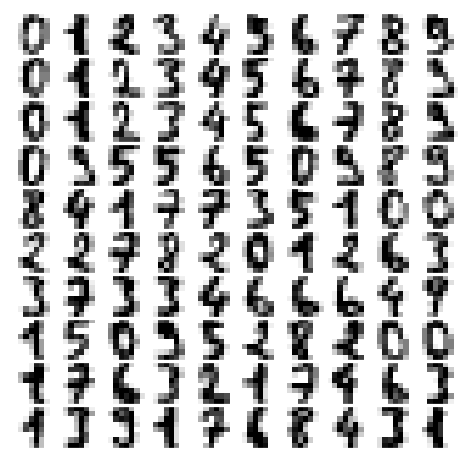

In [66]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
        
plot_digits(digits.data)

In [67]:
from sklearn.decomposition import PCA

pca = PCA(0.99, whiten=True)

data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.

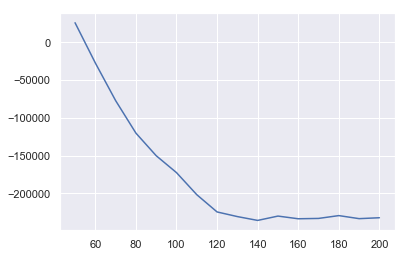

In [68]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]

aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 140 components minimizes the AIC; we will use this model.

In [73]:
gmm = GaussianMixture(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

In [74]:
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

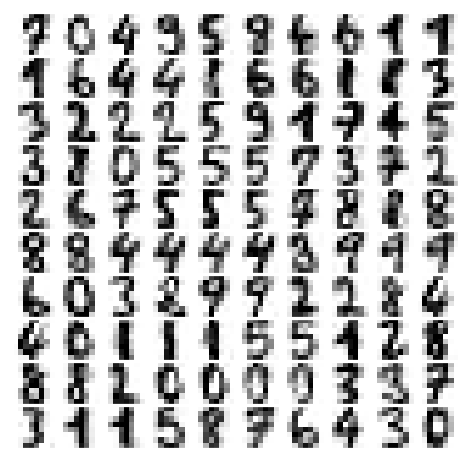

In [75]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

The results for the most part look like plausible digits from the dataset!

## In-Depth: Kernel Density Estimation

In [76]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


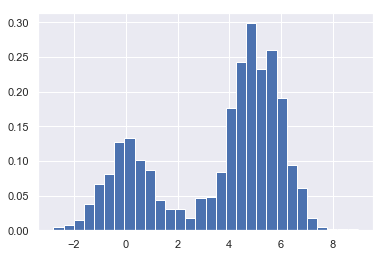

In [77]:
# By specifying the normed parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, 
# but instead reflects probability density
hist = plt.hist(x, bins=30, normed=True)

In [78]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

In [79]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

In [80]:
bins

array([-5.        , -3.33333333, -1.66666667,  0.        ,  1.66666667,
        3.33333333,  5.        ,  6.66666667,  8.33333333, 10.        ])

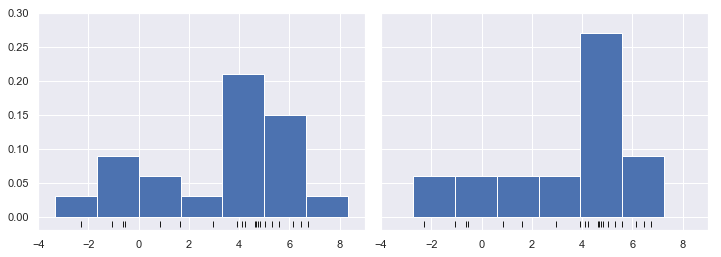

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                              sharex=True, sharey=True,
                              subplot_kw={'xlim':(-4, 9),
                                          'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)

for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

(-0.2, 8)

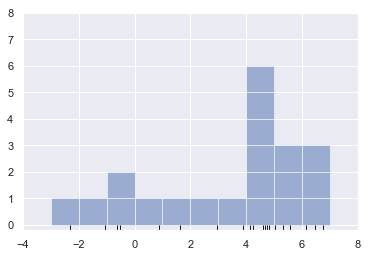

In [82]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)

ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
        
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

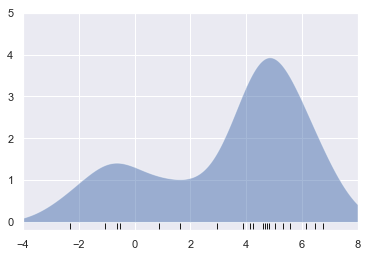

In [83]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

This smoothed-out plot, with a Gaussian distribution contributed at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one that has much less variance

In [84]:
x.shape

(20,)

(-0.02, 0.22)

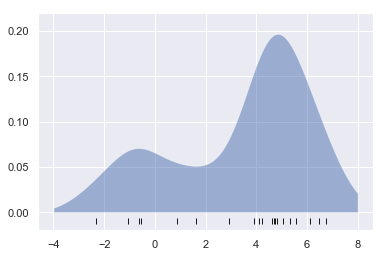

In [85]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

The result here is normalized such that the area under the curve is equal to 1

#### SELECTING THE BANDWIDTH VIA CROSS-VALIDATION

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut())
grid.fit(x[:, None]);

In [90]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

The optimal bandwidth happens to be very close to what we used in the example plot earlier, where the bandwidth was 1.0 (i.e., the default width of scipy.stats.norm).

#### Example: KDE on a Sphere

In [91]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

In [94]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# plot coastlines with Basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

In [ ]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])

    # plot coastlines with Basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()

    # construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

### HOG in Action: A Simple Face Detector

In [95]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()

positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [98]:
from skimage import data, transform, color

imgs_to_use = ['camera', 'text', 'coins', 'moon',
              'page', 'clock', 'immunohistochemistry',
              'chelsea', 'coffee', 'hubble_deep_field']

images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

In [99]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0,
                    patch_size=positive_patches[0].shape):
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                       for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by defau

(30000, 62, 47)

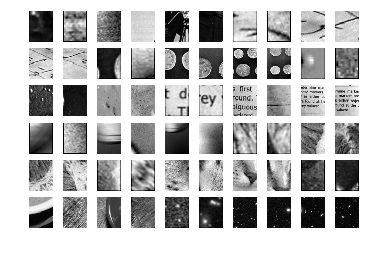

In [100]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [102]:
from itertools import chain
from skimage import feature

X_train = np.array([feature.hog(im)
                   for im in chain(positive_patches,
                                   negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [103]:
X_train.shape

(43233, 1215)

In [104]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.94094789, 0.87481785, 0.93969884])

We see that on our training data, even a simple naive Bayes algorithm gets us upward of 90% accuracy

We will use Scikit-Learn’s LinearSVC, because in comparison to SVC it often has better scaling for large number of samples

In [105]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.986584322161312

In [106]:
grid.best_params_

{'C': 4.0}

In [107]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=4.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


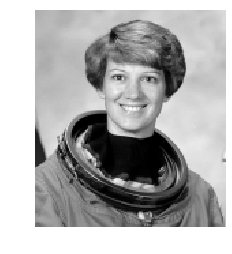

In [109]:
test_image = data.astronaut()
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [110]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                           istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


(1911, 1215)

In [112]:
labels = model.predict(patches_hog)
labels.sum()

33.0

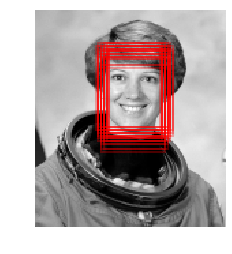

In [113]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2,
                               facecolor='none'))
# Windows that were determined to contain a face